In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# from matplotlib.animation import FuncAnimation
from celluloid import Camera

# from matplotlib.animation import PillowWriter

# import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

import hdbscan
import seaborn as sns
from umap import UMAP


In [2]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 
plt.style.use('dark_background')

In [3]:
football, football_attributes = svg2paths("american-football.svg")
football_marker = parse_path(football_attributes[0]["d"])


# Cluster formations
0. Invert R to L plays
1. Line of scrimmage xy

Offensive and Defensive formations for each play type (kickoff, punt, extra point, and field goal)
Maybe not extra point... due to 2p conversions

In [4]:
game_data = pd.read_csv("data/games.csv")
plays = pd.read_csv("data/plays.csv")


In [5]:
punt_plays = plays[plays["specialTeamsPlayType"] == "Punt"].copy()


In [6]:
# merge game data
punt_plays = punt_plays.merge(game_data, left_on="gameId", right_on="gameId")

In [7]:
# merge game data
all_plays = plays.merge(game_data, left_on="gameId", right_on="gameId")

# Add in tracking for 18, 19, 20 and filter to the first frame only

In [8]:
iter_csv = pd.read_csv("data/tracking2018.csv", iterator=True, chunksize=1e6)
tracking18 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])

iter_csv = pd.read_csv("data/tracking2019.csv", iterator=True, chunksize=1e6)
tracking19 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])

iter_csv = pd.read_csv("data/tracking2020.csv", iterator=True, chunksize=1e6)
tracking20 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])


In [9]:
formation_tracking = pd.concat([tracking18, tracking19, tracking20])


In [10]:
# df = formation_tracking.merge(punt_plays, on=["gameId", "playId"])
df = formation_tracking.merge(all_plays, on=["gameId", "playId"])


In [11]:
# Normalize the data
df["x_norm"] = df["x"]
df["y_norm"] = df["y"]
df["absoluteYardlineNumber_norm"] = df["absoluteYardlineNumber"]

df.loc[df["playDirection"] == "left", "x_norm"] = (
    120 - df.loc[df["playDirection"] == "left", "x"]
)
df.loc[df["playDirection"] == "left", "y_norm"] = (
    53 - df.loc[df["playDirection"] == "left", "y"]
)
df.loc[df["playDirection"] == "left", "absoluteYardlineNumber_norm"] = (
    120 - df.loc[df["playDirection"] == "left", "absoluteYardlineNumber"]
)
# df.loc[df["playDirection"] == "left", "yardlineNumber"] = 50 - df.loc[df["playDirection"] == "left", "x"]


In [12]:
def has_possession(row):
    if (row["team"] == "away") and (
        row["possessionTeam"] == row["visitorTeamAbbr"]
    ):
        return True
    elif (row["team"] == "home") and (
        row["possessionTeam"] == row["homeTeamAbbr"]
    ):
        return True
    else:
        return False


In [13]:
df["has_possession"] = df.apply(has_possession, axis=1)


In [14]:
# should be dist from line of scrimmage
df["x_from_scrimmage"] = df["absoluteYardlineNumber_norm"] - df["x_norm"]

<AxesSubplot:>

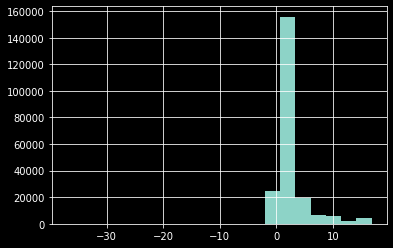

In [15]:
df.loc[df["has_possession"], "x_from_scrimmage"].hist(bins=20)

<AxesSubplot:>

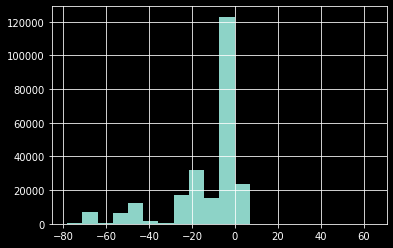

In [16]:
df.loc[~df["has_possession"], "x_from_scrimmage"].hist(bins=20)

In [17]:
# offensive players should all be greater than 0 at the start of the play
# some aren't, let's set the ones greater than a yard off to 0
df.loc[
    (df["x_from_scrimmage"] < -1) & (df["has_possession"]), "x_from_scrimmage"
] = 0

# defensive players should all be less than 0 at the start of the play
# some aren't, let's set the ones greater than a yard off to 0
df.loc[
    (df["x_from_scrimmage"] > 1) & (~df["has_possession"]), "x_from_scrimmage"
] = 0

df["x_from_scrimmage_abs"] = df["x_from_scrimmage"].abs()


In [18]:
# defense
defense_df = df.loc[~df["has_possession"]].copy()

# offense
offense_df = df.loc[df["has_possession"]].copy()


In [19]:
# fig = plt.figure(figsize=(16, 6))
# ax = plt.axes(xlim=(0, 120), ylim=(0, 53))

# home_team = wierd_play.loc[wierd_play["team"] == "home"]
# away_team = wierd_play.loc[wierd_play["team"] == "away"]
# football = wierd_play.loc[wierd_play["team"] == "football"]

# ax.scatter(home_team["x_norm"], home_team["y_norm"], color="#fb8500", s=150)
# ax.scatter(away_team["x_norm"], away_team["y_norm"], color="#118ab2", s=150)
# ax.scatter(
#     football["x_norm"],
#     football["y_norm"],
#     marker=football_marker,
#     color="brown",
#     s=250,
# )
# ax.set_yticks([])
# ax.set_xticks([30, 60, 90])
# ax.set_xticklabels(["20", "50", "20"])
# ax.vlines(
#     home_team["absoluteYardlineNumber_norm"],
#     0,
#     53.3,
#     color="grey",
#     linewidth=2,
#     linestyle="--",
# )
# ax.vlines(10, 0, 53.3, color="black", linestyle="-", alpha=0.5)
# ax.vlines(60, 0, 53.3, color="black", linestyle="-", alpha=0.5)
# ax.vlines(110, 0, 53.3, color="black", linestyle="-", alpha=0.5)


In [20]:
def_min_x = defense_df["x_from_scrimmage_abs"].min()
def_max_x = defense_df["x_from_scrimmage_abs"].max()

off_min_x = offense_df["x_from_scrimmage_abs"].min()
off_max_x = offense_df["x_from_scrimmage_abs"].max()

print(def_min_x, def_max_x)
print(off_min_x, off_max_x)


0.0 78.15
0.0 16.86


In [21]:
x_dim = 100 * 2 # half-yard increments
y_dim = 53 * 2  # roughly half-yard increments

defense_x_range = np.linspace(def_min_x, def_max_x, x_dim)
offense_x_range = np.linspace(off_min_x, off_max_x, x_dim)

y_range = np.linspace(0, 53, y_dim)


In [22]:
def get_closest(array, values):
    # make sure array is a numpy array
    array = np.array(array)

    # get insert positions
    idxs = np.searchsorted(array, values, side="left")

    # find indexes where previous index is closer
    prev_idx_is_less = (idxs == len(array)) | (
        np.fabs(values - array[np.maximum(idxs - 1, 0)])
        < np.fabs(values - array[np.minimum(idxs, len(array) - 1)])
    )
    idxs[prev_idx_is_less] -= 1

    # return array[idxs]
    return idxs


In [23]:
defense_df["x_transformed"] = get_closest(
    defense_x_range, defense_df["x_from_scrimmage_abs"]
)
defense_df["y_transformed"] = get_closest(y_range, defense_df["y_norm"])

offense_df["x_transformed"] = get_closest(
    offense_x_range, offense_df["x_from_scrimmage_abs"]
)
offense_df["y_transformed"] = get_closest(y_range, offense_df["y_norm"])


In [24]:
# ehhh, was going to try mapping these to a field
# mini_field = np.zeros((defense_x_range.shape[0], y_range.shape[0]))


In [25]:
players = defense_df.loc[(defense_df["gameId"] == 2018123000) & (defense_df["playId"] == 36)]
players = players.loc[players["team"] != "football"].copy()
players = players.sort_values(by=["x_transformed", "y_transformed"])
players[["x_transformed", "y_transformed"]].values.flatten()

array([ 33,  44,  41,  94,  42,  10,  42,  77,  43,  28,  46,  59,  61,
        27,  62,  88, 114,  53, 159,  36, 168,  75])

In [26]:
def play_to_array(players):
    # drop the football from the dataframe
    players = players.loc[players["team"] != "football"].copy()
    players = players.sort_values(by=["x_transformed", "y_transformed"])
    assert players.shape[0] == 11
    # print(pd.Series(players[["x_transformed", "y_transformed"]].values.flatten()))
    return players[["x_transformed", "y_transformed"]].values.flatten().tolist()


In [27]:
defense_play_arrays =  defense_df.groupby(["gameId", "playId", "specialTeamsPlayType"]).apply(play_to_array)


In [28]:
offense_play_arrays =  offense_df.groupby(["gameId", "playId", "specialTeamsPlayType"]).apply(play_to_array)


In [29]:
defense_play_arrays.name = "normalized_player_locations"
offense_play_arrays.name = "normalized_player_locations"

In [30]:
defense_play_arrays = defense_play_arrays.to_frame()
offense_play_arrays = offense_play_arrays.to_frame()

In [31]:
# could merge these back in with the original dataframe
# defense_df.merge(defense_play_arrays.to_frame(), left_on=["gameId", "playId"], right_index=True)
# offense_df.merge(offense_play_arrays.to_frame(), left_on=["gameId", "playId"], right_index=True)

## Cluster formations!

In [32]:
defense_players_df = pd.DataFrame(defense_play_arrays["normalized_player_locations"].tolist(), index=defense_play_arrays.index)
offense_players_df = pd.DataFrame(offense_play_arrays["normalized_player_locations"].tolist(), index=offense_play_arrays.index)


In [33]:
umap = UMAP(n_neighbors=151, min_dist=0.05, metric="euclidean", n_components=2)


In [34]:
defense_punt = defense_players_df.loc[defense_players_df.index.get_level_values("specialTeamsPlayType") == "Punt"]
offense_punt = offense_players_df.loc[offense_players_df.index.get_level_values("specialTeamsPlayType") == "Punt"]

defense_kickoff = defense_players_df.loc[defense_players_df.index.get_level_values("specialTeamsPlayType") == "Kickoff"]
offense_kickoff = offense_players_df.loc[offense_players_df.index.get_level_values("specialTeamsPlayType") == "Kickoff"]

defense_extra_point = defense_players_df.loc[defense_players_df.index.get_level_values("specialTeamsPlayType") == "Extra Point"]
offense_extra_point = offense_players_df.loc[offense_players_df.index.get_level_values("specialTeamsPlayType") == "Extra Point"]

defense_field_goal = defense_players_df.loc[defense_players_df.index.get_level_values("specialTeamsPlayType") == "Field Goal"]
offense_field_goal = offense_players_df.loc[offense_players_df.index.get_level_values("specialTeamsPlayType") == "Field Goal"]


In [35]:
defense_punt_umap = umap.fit_transform(defense_punt)
defense_punt_umap = pd.DataFrame(defense_punt_umap, index=defense_punt.index)

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [36]:
defense_punt_umap = defense_punt_umap.merge(
    plays.set_index(["gameId", "playId", "specialTeamsPlayType"])[
        ["specialTeamsResult"]
    ],
    left_index=True,
    right_index=True,
)


In [37]:
punt_labels = hdbscan.HDBSCAN(
    min_samples=15,
    min_cluster_size=250,
).fit_predict(defense_punt_umap[[0, 1]])

In [38]:
defense_punt_umap["cluster"] = punt_labels

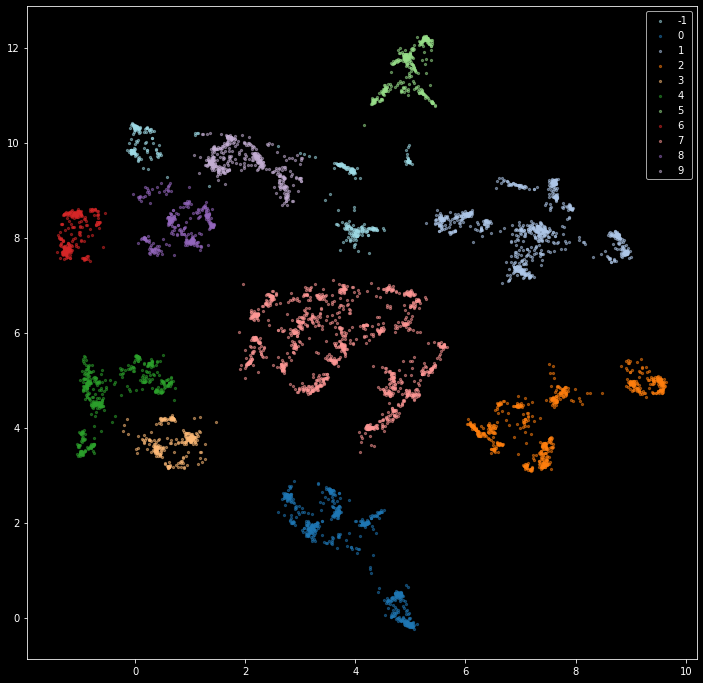

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
# sns.scatterplot(x=0, y=1, hue="cluster", data=defense_punt_umap, cmap="tab20", ax=ax);
for cluster in sorted(defense_punt_umap.cluster.unique()):
    ax.scatter(
        defense_punt_umap.loc[defense_punt_umap.cluster == cluster, 0],
        defense_punt_umap.loc[defense_punt_umap.cluster == cluster, 1],
        s=5,
        alpha=0.5,
        label=cluster,
        color=sns.color_palette("tab20")[cluster],
    )
ax.legend();

1. plot a couple plays
2. plot the mean x,y of sort_values(by=['x','y']). Then plot k football fields, where k is the number of clusters identified. The players would be represented by the average of their x,y coordinates.

Need to figure out extracting offense vs. defense in `plays`

In [49]:
# plot the mean spatially-normed array of each cluster

In [57]:
for cluster in sorted(defense_punt_umap.cluster.unique()):
    defense_punt_umap.loc[defense_punt_umap["cluster"] == cluster][["gameId", "playId"]]
    break

KeyError: "None of [Index(['gameId', 'playId'], dtype='object')] are in the [columns]"

In [41]:
def plot_play(gameid, playid, has_possession=True):
    play = df.loc[(df["gameId"] == gameid) & (df["playId"] == playid) & (df["has_possession"])]

    fig, ax = plt.subplots(figsize=(12, 12))

    fig = plt.figure(figsize=(16, 6))
    ax = plt.axes(xlim=(0, 120), ylim=(0, 53))

    home_team = test_play.loc[test_play["team"] == "home"]
    away_team = test_play.loc[test_play["team"] == "away"]
    football = test_play.loc[test_play["team"] == "football"]

    ax.scatter(home_team["x"], home_team["y"], color="#fb8500", s=150)
    ax.scatter(away_team["x"], away_team["y"], color="#118ab2", s=150)
    ax.scatter(
        football["x"], football["y"], marker=football_marker, color="brown", s=250
    )

    ax.scatter(
        home_team["x_norm"], home_team["y_norm"], color="#fb8500", s=150, marker="x"
    )
    ax.scatter(
        away_team["x_norm"], away_team["y_norm"], color="#118ab2", s=150, marker="x"
    )
    ax.scatter(
        football["x_norm"],
        football["y_norm"],
        marker=football_marker,
        color="brown",
        s=250,
    )

    ax.set_yticks([])
    ax.set_xticks([30, 60, 90])
    ax.set_xticklabels(["20", "50", "20"])
    ax.vlines(10, 0, 53.3, color="black", linestyle="-", alpha=0.5)
    ax.vlines(60, 0, 53.3, color="black", linestyle="-", alpha=0.5)
    ax.vlines(110, 0, 53.3, color="black", linestyle="-", alpha=0.5)


    

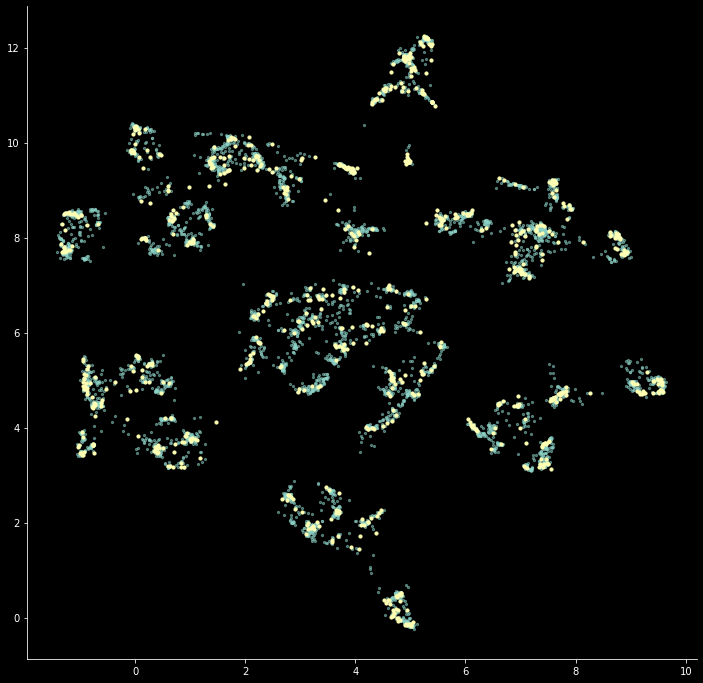

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))

result_type = "Downed"

ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] != result_type, 0
    ],
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] != result_type, 1
    ],
    s=5,
    alpha=0.5,
)
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] == result_type, 0
    ],
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] == result_type, 1
    ],
    s=10,
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


NameError: name 'test_play' is not defined

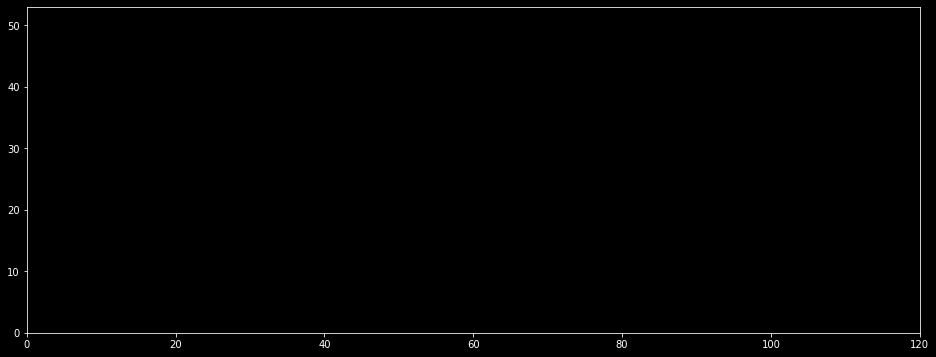

In [44]:
fig = plt.figure(figsize=(16, 6))
ax = plt.axes(xlim=(0, 120), ylim=(0, 53))

home_team = test_play.loc[test_play["team"] == "home"]
away_team = test_play.loc[test_play["team"] == "away"]
football = test_play.loc[test_play["team"] == "football"]

ax.scatter(home_team["x"], home_team["y"], color="#fb8500", s=150)
ax.scatter(away_team["x"], away_team["y"], color="#118ab2", s=150)
ax.scatter(
    football["x"], football["y"], marker=football_marker, color="brown", s=250
)

ax.scatter(
    home_team["x_norm"], home_team["y_norm"], color="#fb8500", s=150, marker="x"
)
ax.scatter(
    away_team["x_norm"], away_team["y_norm"], color="#118ab2", s=150, marker="x"
)
ax.scatter(
    football["x_norm"],
    football["y_norm"],
    marker=football_marker,
    color="brown",
    s=250,
)

ax.set_yticks([])
ax.set_xticks([30, 60, 90])
ax.set_xticklabels(["20", "50", "20"])
ax.vlines(10, 0, 53.3, color="black", linestyle="-", alpha=0.5)
ax.vlines(60, 0, 53.3, color="black", linestyle="-", alpha=0.5)
ax.vlines(110, 0, 53.3, color="black", linestyle="-", alpha=0.5)
